# Analyze Airports dataset

In [4]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.datasets import Airports
from seaborn import color_palette
allcolors=color_palette('colorblind', as_cmap=True)

## load dataset ##
dict = {1:'USA', 2:'Europe', 3:'Brazil'}
name = dict[2]
savepath = f"dataset/precomputed/{name}"
dataset = Airports('dataset/', name)
n_edges = dataset._data.num_edges
n_nodes = dataset._data.num_nodes
n_class = dataset.num_classes
label_to_name = {
    3 : "low",
    2 : "medium low",
    1 : "medium high",
    0 : "high"}
labels_to_eval = list(range(n_class))

In [5]:
def plot_graph(A,node_colors,coords,fig=None,ax=None,s=20):
    if fig is None:
        fig,ax = plt.subplots()
    ax.scatter(coords[:,0],coords[:,1],c=node_colors,s=s)
    G = A.tocoo()
    for ei,ej in zip(G.row,G.col):
        ax.plot(
            [coords[ei][0],coords[ej][0]],
            [coords[ei][1],coords[ej][1]],
            c=allcolors[7],zorder=-10,linewidth=0.2)
    ax.axis('off')
    return fig,ax

In [6]:
## making adjacency matrix ##
G = sp.csr_matrix((np.ones(n_edges), (dataset.edge_index[0], dataset.edge_index[1])), (n_nodes, n_nodes))
x_degree = (G+G.T).sum(0).tolist()[0]
x_degree=np.array(x_degree).astype(int)

## train, validation and testing nodes ##
with open(f"{savepath}/train_nodes.txt","r") as f:
    lines = f.readlines()
    train_nodes = [int(i.strip()) for i in lines]
with open(f"{savepath}/val_nodes.txt","r") as f:
    lines = f.readlines()
    val_nodes = [int(i.strip()) for i in lines]
with open(f"{savepath}/test_nodes.txt","r") as f:
    lines = f.readlines()
    test_nodes = [int(i.strip()) for i in lines]

#compute nodes coordinates
coords_kkl = nx.kamada_kawai_layout(nx.from_scipy_sparse_matrix(G))
coords = np.zeros((n_nodes,2))
for k in range(n_nodes):
    coords[k, 0] = coords_kkl[k][0]
    coords[k, 1] = coords_kkl[k][1]

Plotting the original graph with original labels and predicted lables

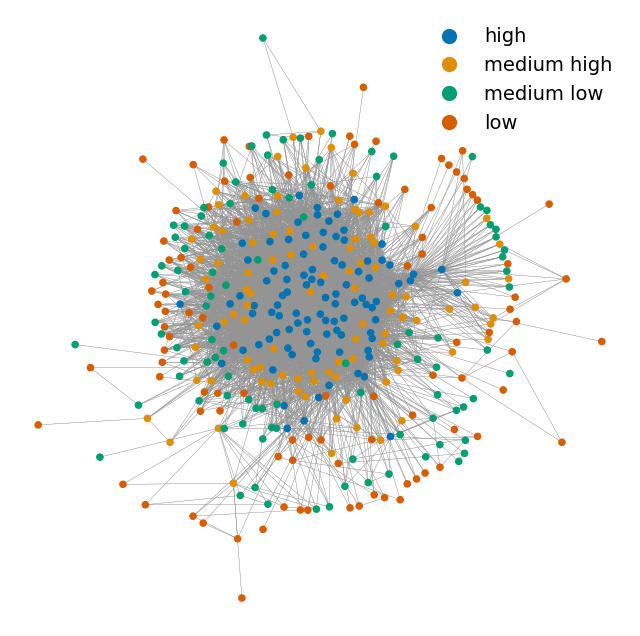

In [7]:
from matplotlib.lines import Line2D

node_colors_class_truth = np.array([allcolors[i] for i in dataset.y])
fig,ax = plt.subplots(figsize=(8,8))
plot_graph(G,node_colors_class_truth,coords,fig=fig,ax=ax,s=20) 
# ax.scatter(coords[train_nodes,0],coords[train_nodes,1],edgecolors=(0,0,0),facecolors=(0,0,0,0),s=30,linewidths=0.6)
# ax.scatter(coords[val_nodes,0],coords[val_nodes,1],edgecolors=(0,0,0),facecolors=(0,0,0,0),s=30,linewidths=0.8)
# ax.set_title('true labels')

patches = []
for label_to_eval in labels_to_eval:
    patches.append(
        Line2D(
            [0],[0],marker='o',markerfacecolor=allcolors[label_to_eval],
            label=f"{label_to_name[label_to_eval]}",color='w',markersize=12))
ax.legend(handles=patches, fontsize=14,framealpha=0,ncol=1)

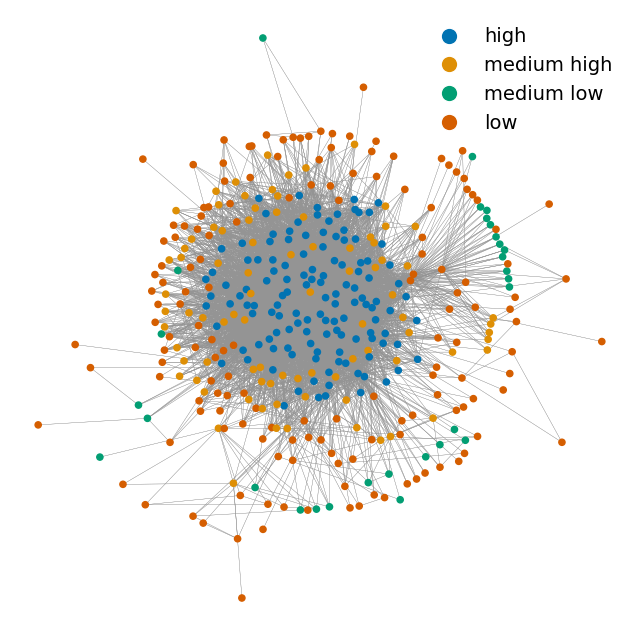

In [8]:
#Predicted lens
preds = np.load(f"{savepath}/prediction_lens.npy")
pred_labels = np.argmax(preds,1)

node_colors_class = np.array([allcolors[i] for i in pred_labels])
fig,ax = plt.subplots(figsize=(8,8))
plot_graph(G,node_colors_class,coords,fig=fig,ax=ax,s=20)
# ax.scatter(coords[train_nodes,0],coords[train_nodes,1],edgecolors=(0,0,0),facecolors=(0,0,0,0),s=30,linewidths=0.6)
# ax.scatter(coords[val_nodes,0],coords[val_nodes,1],edgecolors=(1,0,0),facecolors=(0,0,0,0),s=30,linewidths=1.0) #add a 
# ax.set_title('predicted labels')
ax.legend(handles=patches,framealpha=0,ncol=1, fontsize=14)

In [9]:
count = [0, 0, 0, 0]
count_orig = [0, 0, 0, 0]
tmp = pred_labels
tmp2 = dataset.y
for k in range(len(tmp)):
    count[tmp[k]] += 1
    count_orig[tmp2[k]] += 1

# GTDA 
 Compute Reeb graph and estimated errors

In [10]:
from GTDA.GTDA_utils import compute_reeb, NN_model
from GTDA.GTDA import GTDA

nn_model = NN_model()
nn_model.preds = preds
nn_model.labels = dataset.y.numpy()
nn_model.A = G
nn_model.train_mask = np.zeros(G.shape[0])
nn_model.train_mask[train_nodes] = 1
nn_model.val_mask = np.zeros(G.shape[0])
nn_model.val_mask[val_nodes] = 1
nn_model.test_mask = np.zeros(G.shape[0])
nn_model.test_mask[test_nodes] = 1
smallest_component = 5
overlap = 0.01
GTDA_record = compute_reeb(GTDA,nn_model,labels_to_eval,smallest_component,overlap,extra_lens=None,
    node_size_thd=5,reeb_component_thd=5,nprocs=10,device='cpu',nsteps_mixing=15,split_thd=0.001)#, verbose=True)

Preprocess lens..
Merge reeb nodes...
Build reeb graph...
Total time for building reeb graph is 1.707167387008667 seconds
Compute mixing rate for each sample


In [11]:
from GTDA.GTDA_utils import save_to_json
import networkx as nx
from GTDA.GTDA_utils import find_components, plot_reeb_component
import pandas as pd
from matplotlib.colors import to_rgba

save_to_json(GTDA_record, nn_model, savepath, label_to_name)

gtda = GTDA_record['gtda']
g_reeb = GTDA_record['g_reeb']
reeb_components = find_components(g_reeb,size_thd=0)[1]


Visualizing the Reeb graph obtained with GTDA

100%|██████████| 21/21 [00:00<00:00, 211.59it/s]


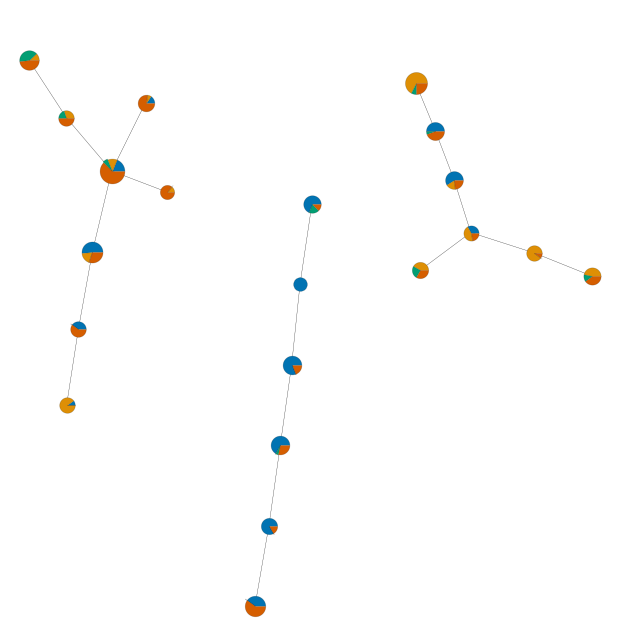

In [12]:
# mapping each Reeb graph component to the actual group of samples it represents
reeb_components_to_nodes = {}
for i,reeb_component in enumerate(reeb_components):
    nodes = []
    for reeb_node in reeb_component:
        # mapping a Reeb node to the actual group of samples it represents
        nodes += gtda.final_components_filtered[gtda.filtered_nodes[reeb_node]]
    if len(nodes) > 0:
        reeb_components_to_nodes[i] = np.unique(nodes)

xcoords = np.zeros(g_reeb.shape[0])
ycoords = np.zeros(g_reeb.shape[0])
g_reeb = g_reeb.tocsr()

for k,c in enumerate(reeb_components):
    g_sub = g_reeb[c,:][:,c]
    pos_tmp = nx.kamada_kawai_layout(nx.from_scipy_sparse_matrix(g_sub),scale=1)
    for i,reeb_node in enumerate(c):
        xcoords[reeb_node] = pos_tmp[i][0]
        ycoords[reeb_node] = pos_tmp[i][1]

for i,c in enumerate(reeb_components):
    shift_x = [-2, 0, 2, -1.5, -1.5]
    shift_y = [2, 0, 2, 2, -1.8]
    scale_x = [1.4, 2, 1.6, 2, 2]
    scale_y = [-2, 2, 1.2, 2, 1.8]
    for j in c:
        xcoords[j] = xcoords[j]*scale_x[i]+shift_x[i]
        ycoords[j] = ycoords[j]*scale_y[i]+shift_y[i]

df = pd.DataFrame({'x':xcoords,'y':ycoords,'sizes':40*gtda.node_sizes[gtda.filtered_nodes]**0.5})

fig,ax = plt.subplots(figsize=(8,8))

g_reeb = g_reeb.tocoo()
for ei,ej in zip(g_reeb.row,g_reeb.col):
    ax.plot(
        [xcoords[ei],xcoords[ej]],
        [ycoords[ei],ycoords[ej]],
        c='white',linewidth=20,zorder=1)

fig,ax = plot_reeb_component(g_reeb,df,gtda.node_colors_class[gtda.filtered_nodes],
    labels_to_eval=[0,1,2],all_class_colors=allcolors,fig=fig,ax=ax,is_plotting_legend=False)

ax.set_xlim(np.min(xcoords)-0.2,np.max(xcoords)+0.4)
ax.set_ylim(np.min(ycoords)-0.2,np.max(ycoords)+0.5)

del xcoords, ycoords

(0.0, 1.0, 0.0, 1.0)

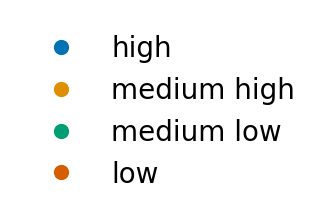

In [13]:
fig_legend,ax_legend = plt.subplots(figsize=(4, 2.5))
ax_legend.legend(handles=patches,fontsize=20,framealpha=0,ncol=1)
ax_legend.axis('off')

100%|██████████| 8/8 [00:00<00:00, 149.16it/s]


Text(0.5, 1.0, 'estimated errors')

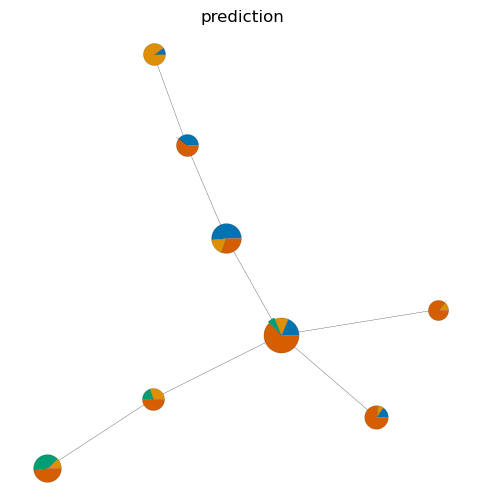

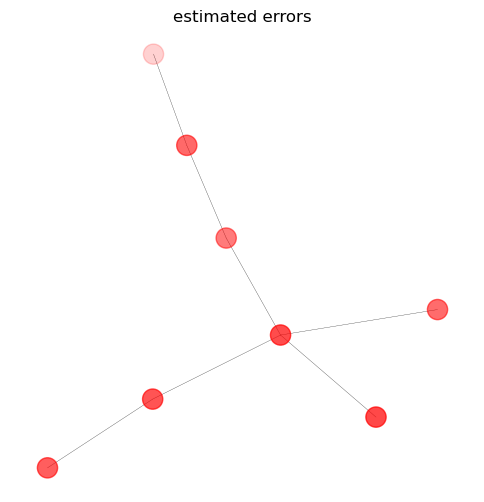

In [14]:
component_index = 0
component = reeb_components[component_index]
g_reeb = g_reeb.tocsr()
g_sub = g_reeb[component,:][:,component]
xcoords = np.zeros(len(component))
ycoords = np.zeros(len(component))
pos_tmp = nx.kamada_kawai_layout(nx.from_scipy_sparse_matrix(g_sub))
for i in range(len(component)):
    xcoords[i] = pos_tmp[i][0]
    ycoords[i] = pos_tmp[i][1]
df = pd.DataFrame({'x':xcoords,'y':ycoords,'sizes':80*gtda.node_sizes[gtda.filtered_nodes[component]]**0.5})

fig,ax = plt.subplots(figsize=(6,6))
fig,ax = plot_reeb_component(g_sub,df,gtda.node_colors_class[gtda.filtered_nodes[component]],
    labels_to_eval=labels_to_eval,all_class_colors=allcolors,fig=fig,ax=ax)
ax.set_title('prediction')

fig,ax = plt.subplots(figsize=(6,6))
node_colors = [(1,0,0,i) for i in gtda.node_colors_mixing[gtda.filtered_nodes[component]]]
fig,ax = plot_reeb_component(g_sub,df,node_colors,
    labels_to_eval=label_to_eval,all_class_colors=allcolors,node_zorder=5,fig=fig,ax=ax,is_plotting_error=True)
ax.set_title('estimated errors')

Plotting a singular Reeb component

100%|██████████| 121/121 [00:00<00:00, 517.30it/s]


(-1.2, 0.9983505622121738)

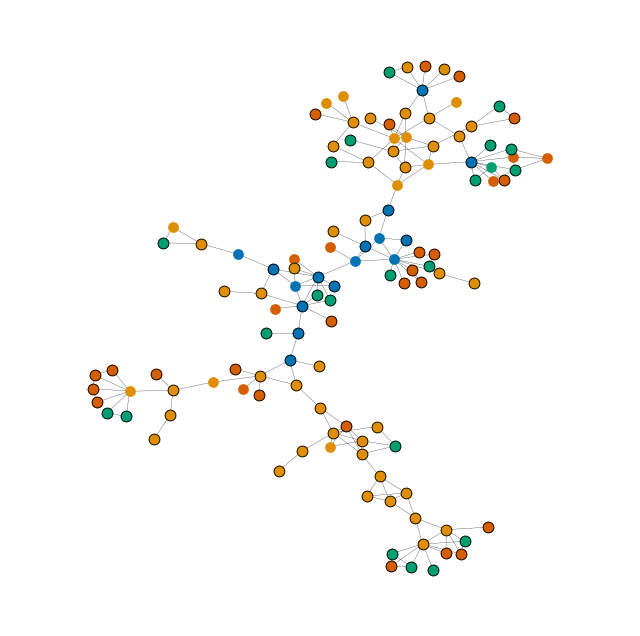

In [15]:
from GTDA.GTDA_utils import plot_subgraph

fig,ax = plt.subplots(figsize=(8,8))
component_index = 2
#plotting the original graph corresponing to the reeb component
nodes = reeb_components_to_nodes[component_index]
subg = gtda.A_reeb[nodes,:][:,nodes]
tmp_pos = nx.kamada_kawai_layout(nx.from_scipy_sparse_matrix(subg))
node_colors_pred = [allcolors[i] for i in pred_labels[reeb_components_to_nodes[component_index]]]
node_colors_truth = [allcolors[i] for i in dataset.y[reeb_components_to_nodes[component_index]]]
tmp_known_nodes = nn_model.train_mask[reeb_components_to_nodes[component_index]] + nn_model.val_mask[reeb_components_to_nodes[component_index]]
fig,ax = plot_subgraph(node_colors_pred,tmp_pos,subg,nodesize=60,fig=fig,ax=ax)
for node in np.nonzero(tmp_known_nodes)[0]:
    ax.scatter(
        [tmp_pos[node][0]],[tmp_pos[node][1]],color=node_colors_truth[node],linewidths=0.6,s=60)
    ax.scatter(
        [tmp_pos[node][0]],[tmp_pos[node][1]],color=(0,0,0,0),linewidths=0.6,edgecolors='black',s=60)

#setting the plot limits
pos=np.zeros([2,len(tmp_pos)])
for i in range(len(tmp_pos)):
    pos[:,i]=tmp_pos[i]

LIM = 0.2
ax.set_xlim(np.min(pos[0])-LIM,np.max(pos[0])+LIM)
ax.set_ylim(np.min(pos[1])-LIM,np.max(pos[1])+LIM)

Visualizing GTDA estimated error

Text(0.5, 1.0, 'model uncertainty')

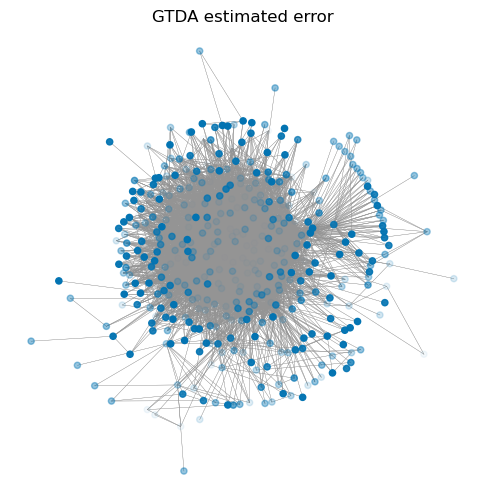

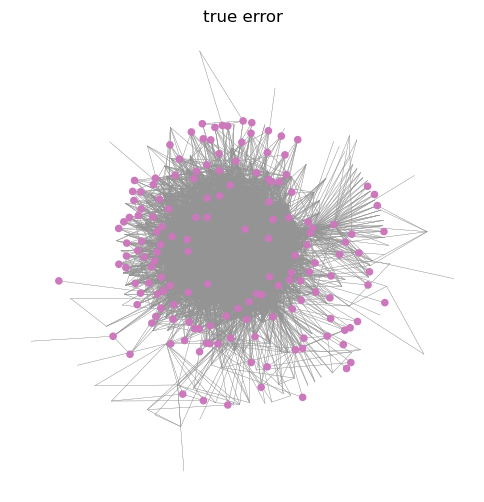

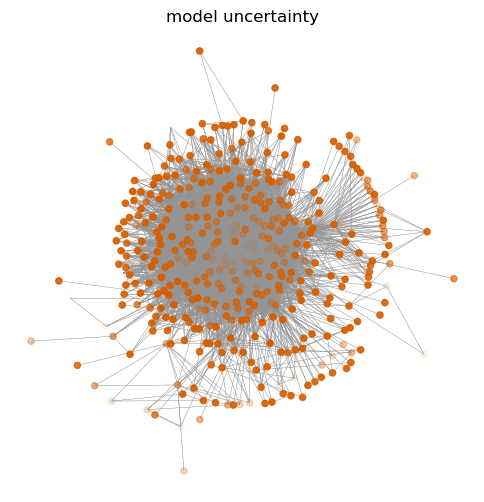

In [16]:
sample_colors_mixing = (gtda.sample_colors_mixing-np.min(gtda.sample_colors_mixing))/(np.max(gtda.sample_colors_mixing)-np.min(gtda.sample_colors_mixing))
sample_colors_mixing = [(to_rgba(allcolors[0]),sample_colors_mixing[i]) for i in range(len(dataset.y))]
fig,ax = plt.subplots(figsize=(6,6))
plot_graph(G,sample_colors_mixing,coords,fig=fig,ax=ax,s=20)
#the following add circles around actual errors 
# ax.scatter(coords[gtda.sample_colors_error==1.,0],coords[gtda.sample_colors_error==1.,1],
#            edgecolors=allcolors[3],facecolors=(0,0,0,0),s=40,linewidths=1.0)
ax.set_title('GTDA estimated error')

sample_colors_error = [(to_rgba(allcolors[4]),gtda.sample_colors_error[i]) for i in range(len(dataset.y))]
fig,ax = plt.subplots(figsize=(6,6))
plot_graph(G,sample_colors_error,coords,fig=fig,ax=ax,s=20)
ax.set_title('true error')

sample_colors_uncertainty = (gtda.sample_colors_uncertainty-np.min(gtda.sample_colors_uncertainty))/(np.max(gtda.sample_colors_uncertainty)-np.min(gtda.sample_colors_uncertainty))
sample_colors_uncertainty = [(to_rgba(allcolors[3]),sample_colors_uncertainty[i]) for i in range(len(dataset.y))]
fig,ax = plt.subplots(figsize=(6,6))
plot_graph(G,sample_colors_uncertainty,coords,fig=fig,ax=ax,s=20)
ax.set_title('model uncertainty')

In [17]:
 # computing nodes mean degree per each class
A = sp.csr_matrix((np.ones(n_edges), (dataset.edge_index[0], dataset.edge_index[1])), (n_nodes, n_nodes))
A = ((A+A.T)>0).astype(int)
X = dataset.x
x_degree = (A+A.T).sum(0).tolist()[0]
x_degree=np.array(x_degree).astype(int)
for k in range(n_nodes):
    X[k,k]=x_degree[k]

degrees_orig = {0:[], 1:[], 2:[], 3:[]}
degrees_pred = {0:[], 1:[], 2:[], 3:[]}
for i in range(n_nodes):
    degrees_orig[dataset.y[i].item()].append(x_degree[i])
    degrees_pred[pred_labels[i]].append(x_degree[i])

mean_degree = [sum(degrees_orig[i])/count_orig[i] for i in range(4)] 
mean_degree_pred = [sum(degrees_pred[i])/count[i] for i in range(4)]

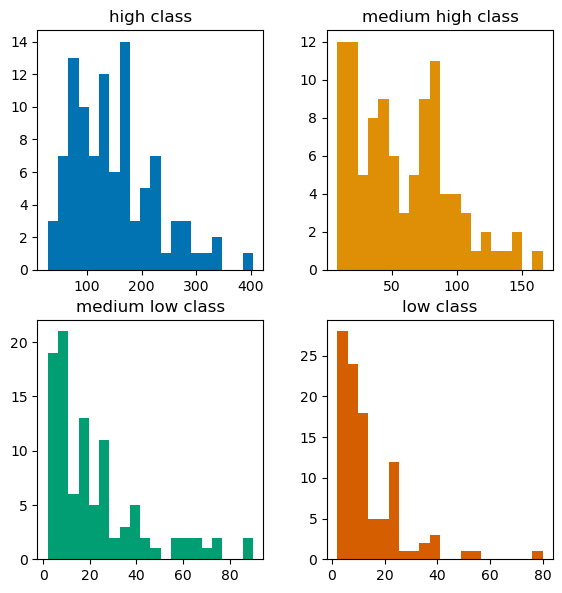

In [18]:
#plotting histograms per original class
fig,axs = plt.subplots(2,2,figsize=(6,6))
ax1 = plt.subplot(2,2,1)
fig.tight_layout(pad=1.5)
ax1.hist(degrees_orig[0], bins=20, color=allcolors[0])
ax1.title.set_text('high class')
ax2 = plt.subplot(2,2,2)
ax2.hist(degrees_orig[1], bins=20, color=allcolors[1])
ax2.title.set_text('medium high class')
ax3 = plt.subplot(2,2,3)
ax3.hist(degrees_orig[2], bins=20, color=allcolors[2])
ax3.title.set_text('medium low class')
ax4 = plt.subplot(2,2,4)
ax4.hist(degrees_orig[3], bins=20, color=allcolors[3])
ax4.title.set_text('low class')

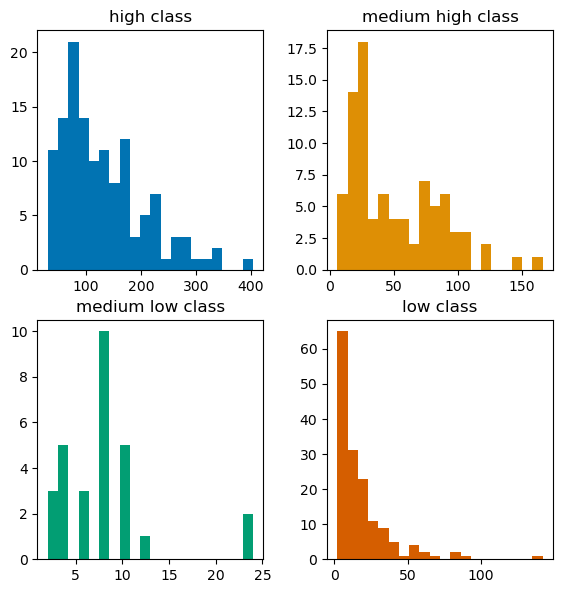

In [19]:
#plotting histograms per predicted class
fig,axs = plt.subplots(2,2,figsize=(6,6))
ax1 = plt.subplot(2,2,1)
fig.tight_layout(pad=1.5)
ax1.hist(degrees_pred[0], bins=20, color=allcolors[0])
ax1.title.set_text('high class')
ax2 = plt.subplot(2,2,2)
ax2.hist(degrees_pred[1], bins=20, color=allcolors[1])
ax2.title.set_text('medium high class')
ax3 = plt.subplot(2,2,3)
ax3.hist(degrees_pred[2], bins=20, color=allcolors[2])
ax3.title.set_text('medium low class')
ax4 = plt.subplot(2,2,4)
ax4.hist(degrees_pred[3], bins=20, color=allcolors[3])
ax4.title.set_text('low class')